This is an example how you run the code manually with your experimental data

Import the necessary libraries and modules

In [1]:
from mobo.mobo import *
from mobo.algorithms import PDBO
import dill
import os
os.environ['OMP_NUM_THREADS'] = '1'  # speed up
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", message="delta_grad == 0.0. Check if the approximated function is linear.")
from arguments import get_args
from baselines.vis_data_export import DataExport
from problems.common import build_problem

1. First, set up the arguments and problem

In [3]:
args, framework_args = get_args()
framework_args= {'surrogate': {'surrogate': 'gp', 'n_spectral_pts': 100, 'nu': 5, 'mean_sample': False},
                 'acquisition': {'acquisition': 'EI'},
                 'solver': {'solver': 'nsga2', 'pop_size': 100, 'n_gen': 10, 'pop_init_method': 'nds', 'n_process': 8, 'batch_size': 1},
                 'selection': {'selection': 'dpp', 'batch_size': 1}}

args.algo = "PDBO"
args.problem = "Reaction_conti"
args.n_var = 5  # number of var
args.n_obj = 2  # number of obj
args.n_process = 1  # number of evalation parallel processes
args.n_init_sample = 10  # initial samples
args.ref_point = None  # ref points
args.batch_size = 1  # batch size

problem, true_pfront, X_init, Y_init = build_problem(args.problem, args.n_var, args.n_obj, args.n_init_sample, args.n_process)
args.n_var, args.n_obj = problem.n_var, problem.n_obj

2. Import initial data from excel, an example csv file can be found in folder 'iteration'

In [4]:
# Start from input data from csv
num = 10
data = pd.read_csv("iteration/InitialSet_conti.csv")
X_init = data.iloc[0:num,0:args.n_var].values
Y_init = data.iloc[0:num,args.n_var:(args.n_var+args.n_obj)].values

You can check the initial data

X_init [[8.44520075e-01 2.26332395e+00 2.55197481e-01 7.12185403e+01]
 [1.44913459e+00 2.71843197e+00 4.85591807e-01 9.48409999e+01]
 [1.01619638e+00 1.64469755e+00 1.70636314e-01 1.07198966e+02]
 [7.23261678e-01 1.87508849e+00 3.11387435e-01 7.72822939e+01]
 [1.69403401e+00 3.10632765e+00 1.08268766e-01 4.36657619e+01]
 [1.80497654e+00 3.87536586e+00 2.85151516e-01 3.82674982e+01]
 [5.33298976e-01 3.45766572e+00 3.46624514e-01 9.26753748e+01]
 [1.85024633e+00 1.34829292e+00 3.80972262e-01 5.46459627e+01]
 [1.16213525e+00 4.80618904e+00 4.20917324e-01 5.94667782e+01]
 [1.33998938e+00 4.51180583e+00 1.83229651e-01 1.19870620e+02]]
Y_init [[ 55.04542691   0.95580418]
 [ 62.8819688    1.10981177]
 [ 32.8294735    0.54659745]
 [ 77.84510584   0.78333779]
 [  8.5387102    2.21638145]
 [ 31.22203427   1.51331816]
 [133.57321153   1.23991086]
 [ 35.51066379   0.60355488]
 [ 74.4327337    1.81162628]
 [ 23.43472184   2.22179851]]


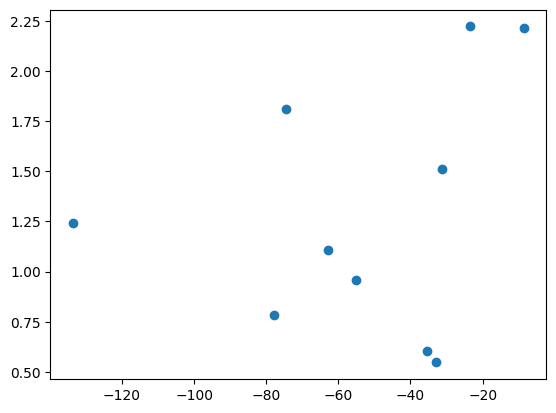

In [5]:
print("X_init", X_init)
print("Y_init",Y_init)
plt.scatter(-Y_init[:,0], Y_init[:,1])
plt.show()


3. Then, initialise the algorithm with the problem and initial data, please note this only needs to be initialised once. For later iterations, you can directly load the information from the pickle file.

In [6]:

obj = PDBO(problem, args.n_iter, args.ref_point, framework_args)

bounds = np.array([problem.xl, problem.xu])
obj.transformation = StandardTransform(bounds)

framework_args['surrogate']['n_var'] = obj.n_var  # for surrogate fitting
framework_args['surrogate']['n_obj'] = obj.n_obj  # for surrogate fitting
framework_args['solver']['n_obj'] = obj.n_obj
framework = init_from_config(obj.config, framework_args)

obj.surrogate_model = framework['surrogate']
obj.acquisition = framework['acquisition']
obj.solver = framework['solver']  # multi-objective solver for finding the paretofront
obj.selection = framework['selection']

obj.X = None
obj.Y = None
obj.sample_num = 0
obj.status = {
    'pset': None,
    'pfront': None,
    'hv': None,
    'ref_point': obj.ref_point,
}

# other component-specific information that needs to be stored or exported
obj.info = None

if obj.ref_point is None:
    obj.ref_point = np.max(Y_init, axis=0)
obj.selection.set_ref_point(obj.ref_point)
obj.acquisition.set_ref_point(obj.ref_point)
obj._update_status(X_init, Y_init)


4. Then run the code and get the next experiment condition

In [7]:

obj.ref_point = [-1.19200271e-01, 2.07504040e+02]  # Set your own reference point if needed
obj.transformation.fit(obj.X, obj.Y)
X, Y = obj.transformation.do(obj.X, obj.Y)
#
# fit gp model (already passed [GaussianProcess object] to obj.)
obj.surrogate_model.fit(X, Y)

# set acquisition function (already passed [AcquisitionAdaptiveHedge object] to obj.)
# obj.acquisition --> methods: set_ref_point, set_args, fit, evaluate, final_batch
obj.acquisition.set_args(obj.selection.batch_size, obj.real_problem, obj.solver,
                          obj.surrogate_model, obj.transformation)

obj.acquisition.fit(X, Y)
res = obj.acquisition.final_batch()

X_next = np.asarray([np.asarray(q) for q in res])
print("X_next", X_next.tolist())

Probability:  [0.25, 0.25, 0.25, 0.25]
Selected acquisition:  UCB
optimization_results (alphas, best y):  [8.95174273e-05 9.99910483e-01] -26.754196116748947
X_next [[1.9996412853864973, 1.0008597665163332, 0.10026704638486729, 105.95969208220747]]


5. Next, you will use the suggested conditions to conduct experiments and get new results. Update your data into X_next and Y_next, and then update the status of the algorithm. Please note that the default setting is both minimisation, so the first value of Y_next should be negative if you want to maximise it. Save the current condition of the algorithm into a pickle file, so that you can load it later for the next iteration.

In [8]:
X_next = np.array([[1.9996412853864973, 1.0008597665163332, 0.10026704638486729, 105.95969208220747]])
Y_next = np.array([[-20, 1.5]])  ### first value is negative!!!
obj._update_status(X_next, Y_next)

exporter = DataExport(obj, obj.X, obj.Y, args)
exporter.update(X_next, Y_next)
exporter.write_csvs()
#
with open("iteration/iteration_1.pkl", "wb") as d:
    dill.dump(obj, d)

6. For the next iteration, simply load the pickle file and continue the process and repeat the steps 4,5 above

In [ ]:
with open("iteration/iteration_1.pkl", "rb") as d:
    obj = dill.load(d)